### This notebook provide the instructions on downloading netcdfs file, extracting relevant data and indexing them via OpenVisus layout.

### Step 1: Importing Libraries


In [1]:
import numpy as np
import OpenVisus as ov
from datetime import datetime
import matplotlib.pyplot as plt
import os
import xarray as xr
import boto3
from botocore import UNSIGNED
from botocore.config import Config
os.environ["VISUS_CACHE"]="./visus_can_be_deleted"

### Step 2: Setting up urls to download the netcdf file

In [2]:
# Constants
s3_url = "s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc"
local_nc = "temp_nc/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc"
field_name = "hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn"
idx_name = "hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950"
year = 1950
dims = [1440, 600]

### Step 3: Downloading the netcdf file locally

In [3]:
# Download from public S3 bucket (no auth)
os.makedirs("temp_nc", exist_ok=True)

bucket = "nex-gddp-cmip6"
key = s3_url.split(bucket + "/")[1]

s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
s3.download_file(bucket, key, local_nc)


In [4]:
ds = xr.open_dataset(local_nc)
data = ds["hurs"].values  # shape: (365, 600, 1440) time, lat, lon
data.shape

(365, 600, 1440)

### Step 4: Read and Convert NetCDF

In [5]:
# Create OpenVisus IDX dataset
field = ov.Field(field_name, "float32")
os.makedirs("idx_dir", exist_ok=True)
idx = ov.CreateIdx(
    url=f"idx_dir/{idx_name}.idx",
    fields=[field],
    time=[year * 365, year * 365 + 364, "time_%d/"],
    arco="modvisus",
    dims=dims,
)

for day in range(365):
    idx.write(data[day], time=year * 365 + day, field=field)

# Cleanup
ds.close()
os.remove(local_nc)
print(f" Converted and wrote IDX: {idx_name}.idx")


 Converted and wrote IDX: hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.idx


### Step 5: Compress Dataset

In [6]:
idx.compressDataset(compression='zip')

### Step 6: Verify the Data

In [7]:
db=ov.LoadDataset(f"idx_dir/{idx_name}.idx")

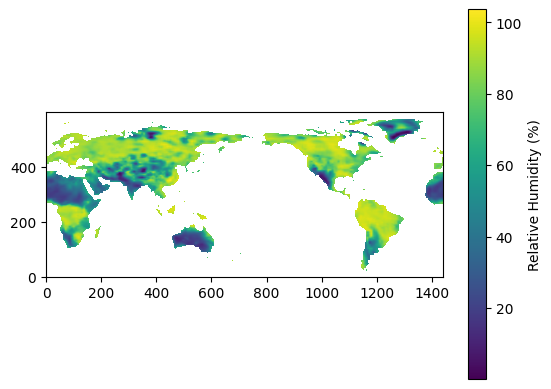

In [8]:
data=db.read()
plt.imshow(data, cmap='viridis',origin='lower')
plt.colorbar(label='Relative Humidity (%)')